In [15]:
from bs4 import BeautifulSoup as bs
import os
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import plotly.express as px
import descartes
import re
from datetime import datetime
import calmap
import geopandas
from pyspark import *
from pyspark.sql import *
from pyspark.sql.functions import *
import re
from pyspark.sql.types import ArrayType
from pyspark.sql.types import StringType
#import geoplot
#import shapefile as shp

from sklearn.linear_model import LinearRegression, LogisticRegression
from VendorsParsingTools import *
from ForumParsingTools import *
from ProductListingParsingTools import *
from libs.milestone2Methods import *
import geopandas
import descartes
import geoplot
import shapefile as shp

# Table of content

## 1) General overview 
    1.0) Used datasets  
    1.1) Files obtained for each day  
    1.2) Services Uptime   
    1.3) Unusable files (celles qu'on a pas réussi à utiliser)  

## 2) Forum Analysis  
    2.1) Selected Features and DF  
    2.2.1) Data quality analysis
    2.2.2) Data Enrichment
    2.3) Index Stats Insight
    2.4) Topics Boards Insight

## 3) Market Analysis  
    3.1) Selected Features  
    3.2.1) Data Quality Analysis  
    3.2.2) Data Enrichment   
    3.3) Vendors Insight  
    3.4) Listings Insight  
   
## 4) Plan  
    4.1) Research Questions 
    4.2) Potential issues
    4.3) Plannification
     


# 1) General overview

## 1.0) Used datasets

###  [_DN Archives (2013-2015)_](https://www.gwern.net/DNM-archives)

  - ##### Description
  The archive contains mostly scrapped _html_ pages from the many marketplaces, forums and other services (e.g. _Grams_ search engine) that were active during the period mentioned in the title. This raw data is organized first by service, then by date (meaning that for every service, one can go to a specific date and see a list of _html_ pages). Every archive is unambiguous on the format of the platform it represents, standard formatting can then be expected (e.g. item, profile, forum thread, list of items, etc.). However it is expected to be highly incomplete and most likely present inconsistencies.  All the directories are compressed using `tar.gz` compression. The whole archive is about `60 GiB` compressed and estimated to be about `1TiB` completely uncompressed.
  - ##### Data Management and Parsing
  Unshaken by the enormous size of this archive, a large amount of processing work was needed in order to filter out all the _html_ formatting data. Due to the difficulty to uncompress the whole archive on the EPFL HDFS storage, we had to manually uncompress only the files we needed and then parse them using spark and beautiful soup.
  - ##### Data Enrichment and Processing
  As mentioned in the source description, the incompleteness of the Dataset is enourmous, we will need to enrich it with other tools, **GRAMMMMMMMMMMMMMMMM**

### [_DNStats_](https://dnstats.net/)
  - #### Description
  **TODO**

## 1.1) Files obtained for each day

/home/arthy/anaconda3/lib/python3.7/site-packages/calmap/__init__.py:221: FutureWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


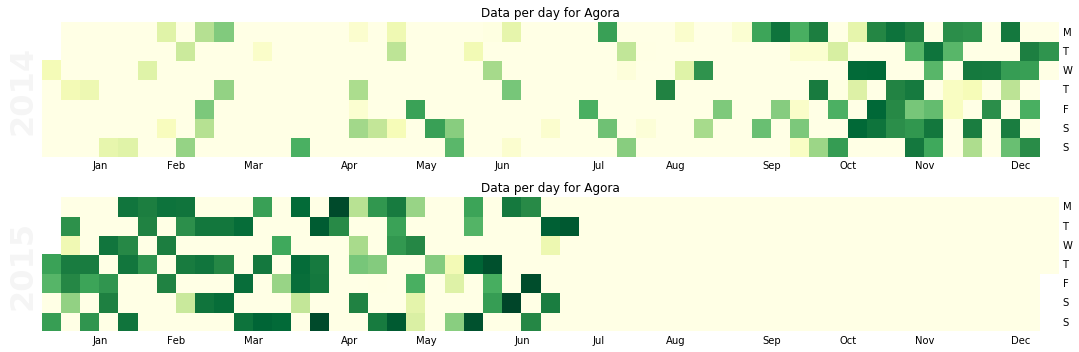

In [3]:
agora_df = pd.read_csv('../data/agora_filesnum.out')
forum_df = pd.read_csv('../data/agora-forum_filesnum.out')
all_days_df = generateFileCount(forum_df, agora_df)
events_ag = pd.Series(all_days_df['filenum_ag'])
events_for = pd.Series(all_days_df['filenum_for'])
calmap.calendarplot(events_ag, daylabels='MTWTFSS', cmap='YlGn', fillcolor='whitesmoke',
                    linewidth=0, fig_kws=dict(figsize=(20, 5)), subplot_kws={'title':'Data per day for Agora'});

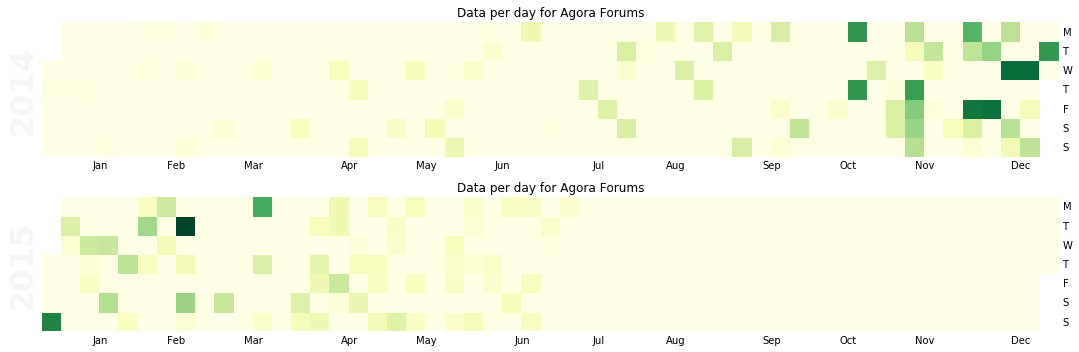

In [4]:
calmap.calendarplot(events_for,daylabels='MTWTFSS',cmap='YlGn', fillcolor='whitesmoke',
                    linewidth=0,fig_kws=dict(figsize=(20, 5)), subplot_kws={'title':'Data per day for Agora Forums'});

>This calendars map show the amount of data per day we have for Agora and Agora Forum. We clearly have a satisfactory amount of data for the market, but we dont have a reliable amount for the forum. There is no stable web scrapping of both websites. In order to understand better this problem, we will study the uptime average of both services in the next part.

## 1.2) Services Uptime

> We then decide to use DNStats which is an up-to-date site tracking darknet markets, products, vendors, news, and more. This way, we can track the amount of available files for each days for Agora depending on the uptime of the sercices, or even see if the Onymous operation had an impact on the services uptime. 


/home/arthy/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



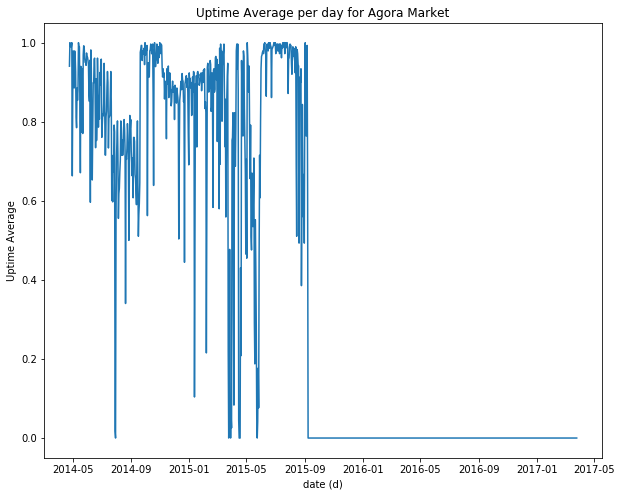

In [5]:
agora_df1 = pd.read_csv('../data/agora_stats.out', sep=",")
agora_df1 = agora_df1.drop(columns=['rid', 'speed_download', 'total_time'])
agora_df1['timestamp'] = agora_df1['timestamp'].apply(pd.to_datetime)

agora_df1['siteup'] = agora_df1['httpcode'].apply(fixIsUp)
agora_df1['timestamp'] = agora_df1['timestamp'].apply(truncateTime)

agora_subdf1 = agora_df1[agora_df1['sitename'] == "Agora"]
forum_subdf1 = agora_df1[agora_df1['sitename'] == "Agora Forums"]

agora_subdf1 = agora_subdf1.groupby(by='timestamp').mean()
forum_subdf1 = forum_subdf1.groupby(by='timestamp').mean()

def plotUptime(x, y, title):
    fig, ax1 = plt.subplots( figsize=(10,8))
    ax1.set_xlabel('date (d)')
    ax1.set_ylabel('Uptime Average')
    ax1.plot(x, y)
    ax1.tick_params(axis='y')
    plt.title(title)
    plt.show()
    
plotUptime(agora_subdf1.index, agora_subdf1['siteup'], 'Uptime Average per day for Agora Market')

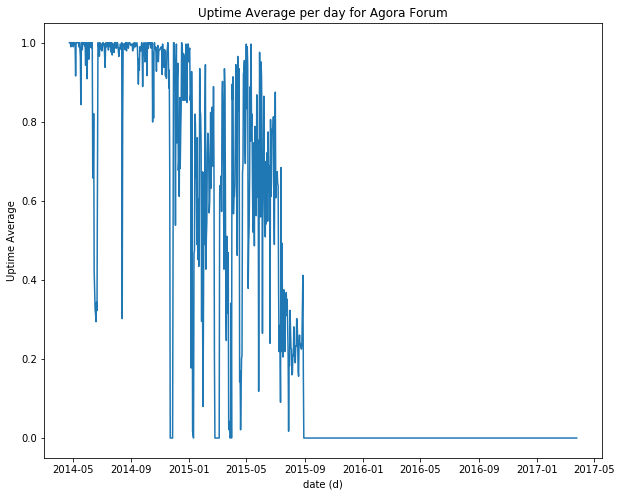

In [6]:
plotUptime(forum_subdf1.index, forum_subdf1['siteup'], 'Uptime Average per day for Agora Forum')

> We observe that the uptime average is very fluctuant over the time for both Agora and Agora Forum. It made the webscrapping quite difficult to do, we have to expect a lot of missing data. Now let's take a look just before and after the Onymous operation: 

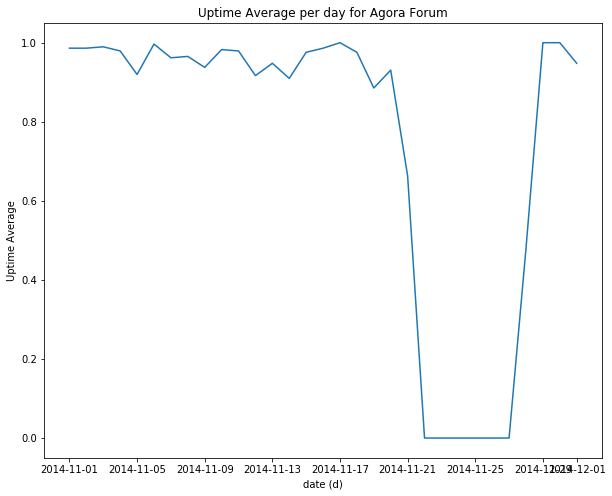

In [7]:
date_range = pd.date_range(start='2014-11-01', end='2014-12-01', freq='D')
plotUptime(forum_subdf1.loc[date_range].index, forum_subdf1['siteup'][date_range], 'Uptime Average per day for Agora Forum')

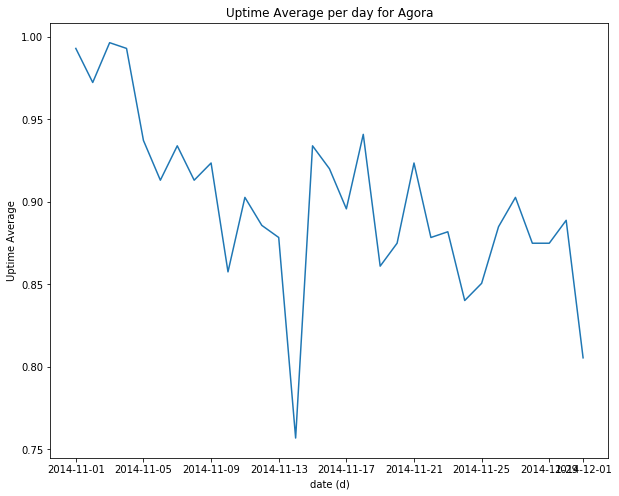

In [8]:
plotUptime(agora_subdf1.loc[date_range].index, agora_subdf1['siteup'][date_range], 'Uptime Average per day for Agora')

Take a look at the period of Operation Onymous and see that there is a fall in the uptime average shortly after both for market and forum, but not at the same time. We also observe that shortly after the drop, the uptime average is back to normal for the forum and it has increased for the market but it tends to slow down.

## 1.3) Unusable Files

# 2) Forum Analysis

In [ ]:
forumDF = pd.read_csv('../saved_gen_df/nPages_nTopicest_nSample_perDayAndBoard.csv')

forum_stats = pd.read_csv('../saved_gen_df/forum_stats_df.csv')

In [ ]:
# Create a feature to store "new posts since last snapshot"
new_posts = pd.Series(np.zeros(len(forumDF['date'])))
forumDF['date'] = forumDF['date'].apply(pd.to_datetime)

# To store days between snapshot
days_elapsed = pd.Series(np.zeros(len(forumDF['date'])))

old_val = 0
old_date = forumDF['date'][0]
for i in range(len(new_posts)):
    diff = (forumDF['date'][i] - old_date).days
    if(diff) == 0:
        diff = 1
    new_posts[i] = (forumDF['posts'][i] - old_val)
    days_elapsed[i] = diff
    old_val = forumDF['posts'][i]
    old_date = forumDF['date'][i]
    
forumDF['new_posts'] = new_posts
forumDF['days_elapsed'] = days_elapsed

In [ ]:
fig, ax1 = plt.subplots(figsize=(10,5))

ax1.set_xlabel('date (s)')
ax1.set_ylabel('New Posts / day since last measure')
ax1.plot(forumDF['date'], forumDF['new_posts'])
ax1.tick_params(axis='y')

plt.yscale('symlog')
plt.show()

In [10]:
forumDF = pd.read_csv('../saved_gen_df/forumDF_full_df.csv')

# 3) Market Analysis

## 3.2.2) Data Enrichment

In [11]:
price_df = pd.read_csv('../saved_gen_df/prices_and_stuff.csv')
price_df = price_df.drop(columns=['mean', 'std', 'min', '25%', '75%'])

In [16]:
# Get world mat
world = geopandas.read_file(
    geoplot.datasets.get_path('world')
)
sf = shp.Reader('../data/ne_50m_admin_0_countries.shp')
world_df = read_shapefile(sf)

In [17]:
world_df = world_df[['NAME', 'CONTINENT']]
world_df.rename(columns={'NAME':'name'}, inplace=True)
world_df = pd.merge(world, world_df, how='inner')

In [18]:
world_df['count'] = 0
world_df['continent_count'] = 0

In [19]:
DATE = "2015-07-12"
world_df['count'] = world_df['name'].apply((lambda x : fillCountryCount(x,DATE)))
world_df['continent_count'] = world_df['CONTINENT'].apply((lambda y : fillContinentCount(y, DATE)))

In [20]:
world_df.to_csv("../saved_gen_df/listing_count_"+DATE+"_map_df.csv")

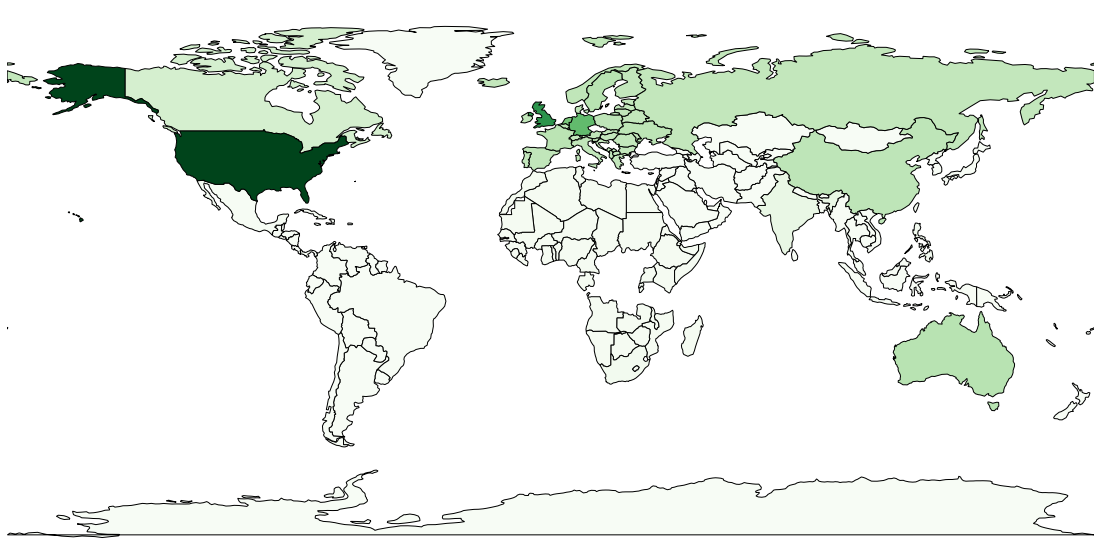

In [21]:
geoplot.choropleth(world_df, hue=world_df['count']+world_df['continent_count'],cmap='Greens', figsize=(20, 10));

In [22]:
DATE = "2014-06-09"
world_df['count'] = world_df['name'].apply((lambda x : fillCountryCount(x,DATE)))
world_df['continent_count'] = world_df['CONTINENT'].apply((lambda y : fillContinentCount(y, DATE)))

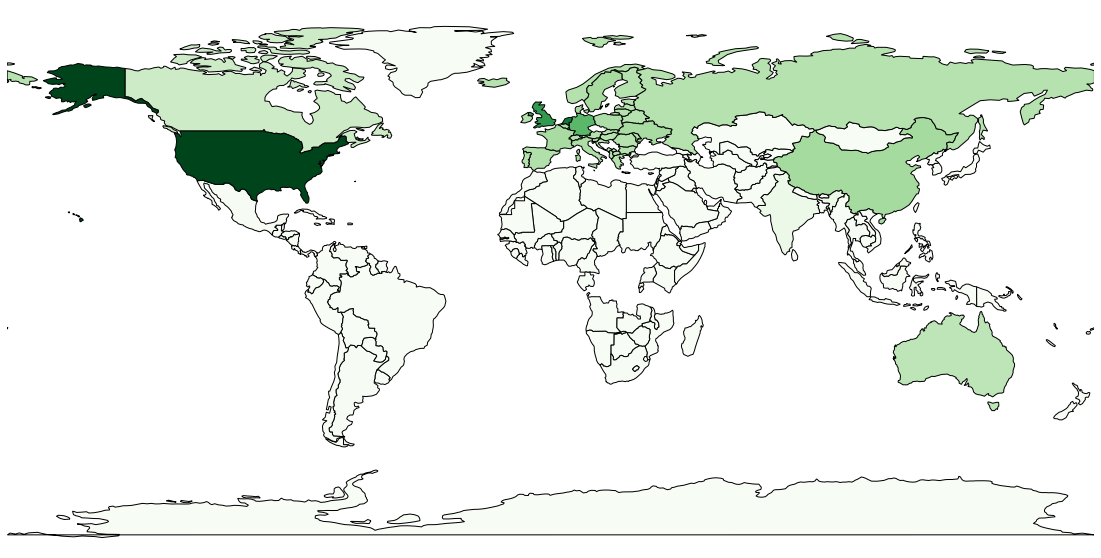

In [23]:
geoplot.choropleth(world_df, hue=world_df['count']+world_df['continent_count'],cmap='Greens', figsize=(20, 10));

## 3.3) Vendors Insight

In [24]:
directory = "../data/agora/2014-04-06/vendor"
vendors = createVendorsDF(directory)

In [25]:
vendors.head(10)

,name,rating,lastSeen,publicKey,#products,#Deals
0,tomsmith0626,4.94,4 hours,-----BEGIN PGP PUBLIC KEY BLOCK-----Version: G...,18,55~70
1,Snowball_II,5,5 hours,-----BEGIN PGP PUBLIC KEY BLOCK-----Version: G...,4,1~2
2,Passport_Connection,5,0 hours,-----BEGIN PGP PUBLIC KEY BLOCK-----Version: P...,27,6~10
3,NOCTURN4L,4.94,8 hours,-----BEGIN PGP PUBLIC KEY BLOCK-----Version: G...,9,150~200
4,nawlins,4.88,9 hours,-----BEGIN PGP PUBLIC KEY BLOCK-----Version: G...,18,70~100
5,carlos_lopez,4.96,1 hours,-----BEGIN PGP PUBLIC KEY BLOCK-----Version: G...,4,40~55
6,NarcoticSalesAustralia,None,1 days 15 hours,-----BEGIN PGP PUBLIC KEY BLOCK-----Version: B...,3,0
7,FreedomNow,4.82,4 days,-----BEGIN PGP PUBLIC KEY BLOCK-----mQSuBFMFqP...,2,25~40
8,OxyWave,5.00,5 hours,-----BEGIN PGP PUBLIC KEY BLOCK-----Version: G...,6,25~40
9,THCXpert,5.00,11 hours,-----BEGIN PGP PUBLIC KEY BLOCK-----mQSuBFK3W4...,21,25~40


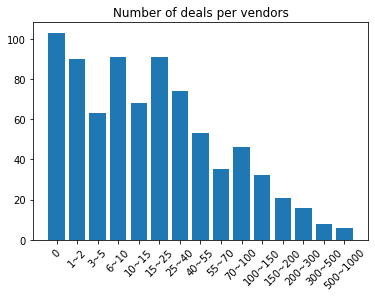

In [26]:
sortedStats = createStatsAboutNumbOfDeals(Counter(vendors['#Deals']))
plt.bar(sortedStats.keys(),sortedStats.values());
plt.xticks(rotation=45);
plt.title('Number of deals per vendors');

In [27]:
max(vendors['#products'])

AttributeError: 'NoneType' object has no attribute '_jvm'

In [ ]:
vendors['#products'].plot.hist(bins=50, logy=True)
plt.title('Number of products per vendor')
plt.xlabel('number of products')
plt.ylabel('number of vendors')
plt.show()

## 3.4) Listing insight

In this section, we will try to understand all the products listed in agora-market that we managed to retrieve.

In [ ]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
df = spark.read.option("header", "true").csv("../data/cat_csv/*.csv")
df.count()

> So in total we have 2805212 products, we selected the following features: 

In [ ]:
df.printSchema()

> After some analysis, we cleaned the data as follow: 

In [ ]:
def processCountries(country):
    # Remove html tags
    cleanr = re.compile('<.*?>')
    cleanText = str(re.sub(cleanr, '', str(country)))
    
    # Remove spaces
    cleanText = cleanText.strip(' ')
    
    # Remove ""
    cleanText = cleanText.strip('"')
    
    # Split for each country
    cleanText = re.split("&|,|/", cleanText)
    
    return cleanText

udf_func_C = udf(processCountries, ArrayType(StringType()))

def processCatHashs(cat_hash):
    # Remove html end of files
    cleanr = re.compile('.\d*.html')
    cleanText = str(re.sub(cleanr, '', str(cat_hash)))
    return cleanText

udf_func_H = udf(processCatHashs, StringType())

# Remove rows without a valid date, error during parsing, file not complete
df = df.filter(df["date"].rlike("\d\d\d\d-\d\d-\d\d"))

# Remove rows without a price or not decimal, 642 in total, mainly due to error during parsing.
df = df.filter("CAST(price AS DECIMAL) is not null")

# Remove the rows where name is null, all the columns are usually null in this case, (6 rows)
df = df.filter("name is not null")

# Lowercase and process the countries
df=df.withColumn("to", lower(col("to")))
df=df.withColumn("to", udf_func_C(col("to")))

# Lowercase and process the countries
df=df.withColumn("from", lower(col("from")))
df=df.withColumn("from", udf_func_C(col("from")))

# Process the hashs
df=df.withColumn("cat_hash", udf_func_H(col("cat_hash")))

> Once our data cleaned, we wanted to know if the number of listing per day parsed was consistent

In [ ]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns

pdDF = df.groupby("date").agg(count("date")).toPandas()
pdDF = pdDF[pdDF['date'].str.contains("\d\d\d\d-\d\d-\d\d")]
pdDF['date'] = pd.to_datetime(pdDF['date'],infer_datetime_format=True) 
pdDF = pdDF.sort_values(by='date', ascending=True, na_position='first')

# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(pdDF['date'],
        pdDF['count(date)'],
        '-o',
        color='purple')
ax.set(xlabel="Date", ylabel="# of products",
       title="Number of products per day")

# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
plt.show()

> We can see here that we have a lot of missing values, the number of products increase linearly but it drop a lot unpredictably

In [ ]:
categories_per_day = df.groupby("date", "cat_hash").agg(count("cat_hash")).groupby("date").agg(count("cat_hash")).toPandas()
categories_per_day = categories_per_day[categories_per_day['date'].str.contains("\d\d\d\d-\d\d-\d\d")]
categories_per_day['date'] = pd.to_datetime(categories_per_day['date'],infer_datetime_format=True) 
categories_per_day = categories_per_day.sort_values(by='date', ascending=True, na_position='first')
categories_per_day = categories_per_day.rename(columns={'count(cat_hash)': 'catNumber'})

max_categories_per_day = categories_per_day.groupby([categories_per_day.date.dt.month, categories_per_day.date.dt.year]).max()
max_categories_per_day = max_categories_per_day.reset_index(drop=True)
max_categories_per_day = max_categories_per_day.sort_values(by='date', ascending=True, na_position='first')

# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(max_categories_per_day['date'],
        max_categories_per_day['catNumber'],
        '-o',
        color='purple')
ax.set(xlabel="Date", ylabel="# of categories",
       title="Number of categories per day")

# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=10))
plt.show()


> We can see here that if we pick one day per month with the maximum number of categories parsed, the result seems more predictable than before, it could be a solution to our missing data problem. We still need to dig a bit into different solution in order to plot the correct # of products or categories by day. 

# 4) Plan

##  4.1) Research questions

Due to the large amount of time needed to process the data and handle missing data, we will restrict a bit our research questions : 

* How did it affect the global sales on a short and a longer timescale ?
* How was the user traffic affected ?
* How was the "online traffic" popularity affected ?
* Were there any trends in the forums during this kind of intervention ?
* How did the prices evolve globally ?




## 4.2) Potential issues

The main issues of this project are caused by the missing data, it is very complicated to give meaningful information when we cannot be certain that we cover all the services.

## 4.3) Plannification

  - #### Dec 2th
  Data enrichment 
  Depth analysis of the data.
  Answer research questions.
  - #### Dec 9th
  Create meaningful vizualisation for the results.
  Put all together in a beautiful data story.
  - #### Dec 17th
  Finish producing content for the data story.

  ***
  - #### Dec 20th DEADLINE
  Finalize the data story for submission.
  ***